# Options Handler Tutorial
Varying options with time is a well regarded technique in particle swarm optimization for faster convergence and
better solutions. This class exposes methods to do the same.

In this example, we will demonstrate some common variation techniques along with some [visualisation].
- `oh_strategy`: a dictionary containing the strategies for each option
- `end_opts`: a dictionary containing the ending options for each option
- `plot_cost_history`: for plotting the cost history of a swarm given a matrix
- `plot_contour`: for plotting swarm trajectories of a 2D-swarm in two-dimensional space

[visualisation]: https://github.com/ljvmiranda921/pyswarms/blob/master/docs/examples/tutorials/visualization.ipynb


In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour)

from pyswarms.backend.handlers import OptionsHandler

Let's create some optimizers for comparison. Here, we're going to use Global-best PSO to find the minima
of a sphere function. As usual, we simply create an instance of its class `pyswarms.single.GlobalBestPSO`
by passing the required parameters that we will use. Then, we'll call the `optimize()` method for 100 iterations for both and visualise the results

In [2]:
options = {'c1':0.5, 'c2':0.3, 'w':0.9}  # starting options
optimizer_without_handle=ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options=options)
optimizer_with_handle = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options=options, oh_strategy={"w":'exp_decay', 'c1':'lin_variation'})

cost, pos = optimizer_without_handle.optimize(fx.sphere, iters=100)
cost_h, pos_h = optimizer_with_handle.optimize(fx.sphere, iters=100)


2020-12-11 19:23:18,434 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.95e-10
2020-12-11 19:23:18,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.946552028624106e-10, best pos: [ 2.74938126e-05 -6.22458616e-06]
2020-12-11 19:23:18,541 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.99e-28
2020-12-11 19:23:18,648 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.987498732542365e-28, best pos: [ 7.14102116e-15 -2.73451219e-14]


## Comparing the cost history

To plot the cost history, we simply obtain the `cost_history` from the `optimizer` class and pass it to the `cost_history` function. In addition, we can obtain the following histories from the same class:
- mean_neighbor_history: average local best history of all neighbors throughout optimization
- mean_pbest_history: average personal best of the particles throughout optimization

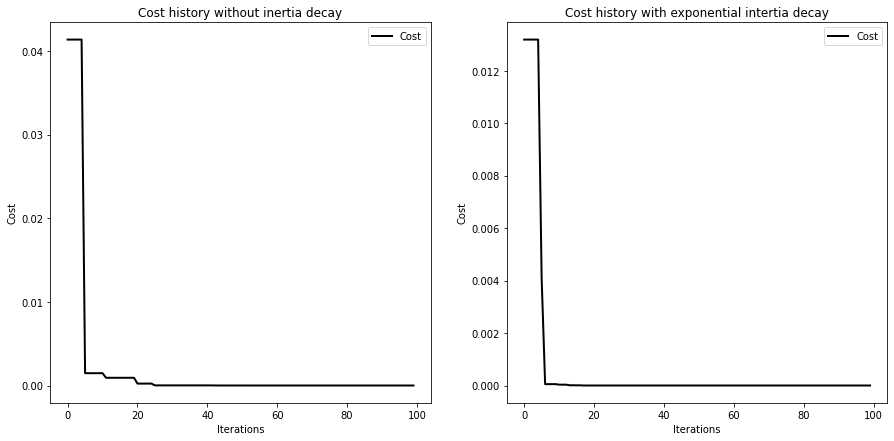

In [3]:
fig, (ax, ax_h) = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(15,7)
plot_cost_history(ax=ax, cost_history=optimizer_without_handle.cost_history)
plot_cost_history(ax=ax_h, cost_history=optimizer_with_handle.cost_history)
ax.set_title("Cost history without inertia decay")
ax_h.set_title("Cost history with exponential intertia decay")
plt.show()

The rapid decay of the inertia weight contributes significantly to the overall best cost and position. It also converges a lot faster.

The next part shows the explanation for this with an animation

## Comparing animations
The `plotters` module offers two methods to perform animation, `plot_contour()`. This method plot the particles in a 2-D space.

The objective function contours are added using the `Mesher` class.


In [4]:
from pyswarms.utils.plotters.formatters import Mesher
# Initialize mesher with sphere function
m = Mesher(func=fx.sphere)

### Plotting in 2-D space

We can obtain the swarm's position history using the `pos_history` attribute from the `optimizer` instance. To plot a 2D-contour, simply pass this together with the `Mesher` to the `plot_contour()` function. In addition, we can also mark the global minima of the sphere function, `(0,0)`, to visualize the swarm's "target".

In [5]:
%%capture

# Make and save animation
animation = plot_contour(pos_history=optimizer_without_handle.pos_history,
                         mesher=m,
                         mark=(0,0))
animation_h = plot_contour(pos_history=optimizer_with_handle.pos_history,
                         mesher=m,
                         mark=(0,0))
# Enables us to view it in a Jupyter notebook
animation.save('ani.gif', writer='imagemagick', fps=10)

animation_h.save('ani_h.gif', writer='imagemagick', fps=10)



2020-12-11 19:23:22,596 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2020-12-11 19:23:22,597 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2020-12-11 19:23:30,971 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2020-12-11 19:23:30,973 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


Compare the two animations. Observe the convergence time and particle overshoot in both figures.

Left: Without handle

Right: With handle

<img src="ani.gif" width="450" align="left">
<img src="ani_h.gif" width="450" align="right">



## Customizing ending options

As of the current version(1.2.0), you'll need to create your own optimization loop to keep custom ending options.
The next block shows a basic implementation of this without logging etc.

In [6]:
from pyswarms.backend.operators import compute_pbest, compute_objective_function

In [10]:
def optimize(objective_func, maxiters, oh_strategy,start_opts, end_opts):
    opt = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options=start_opts, oh_strategy=oh_strategy)

    swarm = opt.swarm
    opt.bh.memory = swarm.position
    opt.vh.memory = swarm.position
    swarm.pbest_cost = np.full(opt.swarm_size[0], np.
    inf)

    for i in range(maxiters):
        # Compute cost for current position and personal best
        swarm.current_cost =  compute_objective_function(swarm, objective_func)
        swarm.pbest_pos, swarm.pbest_cost = compute_pbest(swarm)

        # Set best_cost_yet_found for ftol
        best_cost_yet_found = swarm.best_cost
        swarm.best_pos, swarm.best_cost = opt.top.compute_gbest(swarm)
        # Perform options update
        swarm.options = opt.oh( opt.options, iternow=i, itermax=maxiters, end_opts=end_opts )
        print("Iteration:", i," Options: ", swarm.options)    # print to see variation
        # Perform velocity and position updates
        swarm.velocity = opt.top.compute_velocity(
            swarm, opt.velocity_clamp, opt.vh, opt.bounds
        )
        swarm.position = opt.top.compute_position(
            swarm, opt.bounds, opt.bh
        )
    # Obtain the final best_cost and the final best_position
    final_best_cost = swarm.best_cost.copy()
    final_best_pos = swarm.pbest_pos[
        swarm.pbest_cost.argmin()
    ].copy()
    return final_best_cost, final_best_pos

In the next cell, you can play around with the start and end options, maximum iterations and the function itself to compare the outputs like above.

In [12]:
function = fx.rosenbrock    # optimum at [1,1]
maxiters = 100
start_opts = {'c1':2.5, 'c2':0.5, 'w':0.9}
end_opts= {'c1':0.5, 'c2':2.5, 'w':0.4}     # Ref:[1]
oh_strategy={ "w":'exp_decay', "c1":'nonlin_mod',"c2":'lin_variation'}

cost, pos=optimize(function, maxiters, oh_strategy, start_opts, end_opts)

print("Best cost = ", cost)
print("Best position = ", pos)

Iteration: 0  Options:  {'c1': 2.5, 'c2': 0.5, 'w': 0.8154845485377135}
Iteration: 1  Options:  {'c1': 2.476024064289623, 'c2': 0.52, 'w': 0.7638427274927154}
Iteration: 2  Options:  {'c1': 2.4520965166602724, 'c2': 0.54, 'w': 0.7212425273766464}
Iteration: 3  Options:  {'c1': 2.428217751727513, 'c2': 0.56, 'w': 0.6855550181382926}
Iteration: 4  Options:  {'c1': 2.4043881714225273, 'c2': 0.5800000000000001, 'w': 0.6552602432446853}
Iteration: 5  Options:  {'c1': 2.3806081852052783, 'c2': 0.6000000000000001, 'w': 0.6292465903435571}
Iteration: 6  Options:  {'c1': 2.3568782102861965, 'c2': 0.6200000000000001, 'w': 0.6066838570323415}
Iteration: 7  Options:  {'c1': 2.3331986718568167, 'c2': 0.6399999999999999, 'w': 0.5869404779457066}
Iteration: 8  Options:  {'c1': 2.3095700033298305, 'c2': 0.6599999999999999, 'w': 0.5695280957195421}
Iteration: 9  Options:  {'c1': 2.285992646589043, 'c2': 0.6799999999999999, 'w': 0.5540635587607113}
Iteration: 10  Options:  {'c1': 2.2624670522497583, 'c2

Changing options clearly shows better convergence. Just 100 iterations on the rosenbrock function are enough to bring the cost to very low orders of e-10 which is comparable to the ones in academia. [2]

References:

[1] Chih, Mingchang, et al. "Particle swarm optimization with time-varying acceleration coefficients for the multidimensional knapsack problem." Applied Mathematical Modelling 38.4 (2014): 1338-1350.

[2] Satyanarayana Daggubati, "Comparison of particle swarm optimization variants"